In [1]:
import torch, random, torch.nn as nn
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# 1. Hyper-parameters ---------------------------------------------------------
EMB_DIM  = 256          # was 128
PRED_DIM = 256         # was 256
PATCH_SZ  = 18      # target patch size
LR        = 3e-4
BATCH     = 256
EPOCHS    = 15
PRED_DIM = 128          # was 256


In [4]:
class Encoder(nn.Module):
    def __init__(self, out_dim=EMB_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 128, 3, padding=1), nn.ReLU(),        # 28×28
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(),  # 14×14
            nn.Conv2d(256, 256, 3, stride=2, padding=1), nn.ReLU(),  # 7×7
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, out_dim)
        )
    def forward(self, x):
        return self.net(x)

In [5]:
# class Predictor(nn.Module):
#     """MLP: z_x → ẑ_y"""
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(EMB_DIM, PRED_DIM), nn.LayerNorm(PRED_DIM), nn.ReLU(),
#             nn.Linear(PRED_DIM, EMB_DIM)
#         )
#     def forward(self, z_x):
#         return self.net(z_x)

In [6]:
class MicroViT(nn.Module):
    def __init__(self, out_dim=EMB_DIM):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, 192, 7, stride=7)  # 4×4 patches
        self.pos_embed   = nn.Parameter(torch.zeros(1, 16, 192))
        encoder_layer = nn.TransformerEncoderLayer(d_model=192, nhead=4,
                                                   dim_feedforward=384,
                                                   dropout=0.1, activation='gelu',
                                                   batch_first=True)
        self.blocks = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.norm = nn.LayerNorm(192)
        self.head = nn.Linear(192, out_dim)

    def forward(self, x):
        x = self.patch_embed(x).flatten(2).transpose(1, 2)  # B,16,192
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x.mean(1))      # global average
        return self.head(x)

In [7]:
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(EMB_DIM, PRED_DIM),
            nn.LayerNorm(PRED_DIM),
            nn.ReLU(),
            nn.Dropout(0.4),                # <- raise dropout
            nn.Linear(PRED_DIM, EMB_DIM)
        )
    def forward(self, z):
        return self.net(z)

In [8]:
# 3. Data --------------------------------------------------------------------
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.15)),  # drop random 2–15 %
    #transforms.RandomRotation(degrees=15),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_set = datasets.MNIST(root='.', train=True, download=True, transform=transform_train)
loader    = torch.utils.data.DataLoader(train_set, batch_size=BATCH, shuffle=True, drop_last=True) # training the encoder 

In [9]:
# 4. Model & optim -----------------------------------------------------------
x_enc = Encoder().to(device)
y_enc = Encoder().to(device)   # will be updated by EMA
predictor = Predictor().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

x_enc.apply(weights_init)
y_enc.apply(weights_init)

for p in y_enc.parameters():   # no gradients flow through y-encoder
    p.requires_grad = False

opt = torch.optim.AdamW(
    [{'params': x_enc.parameters(), 'weight_decay': 1e-4},
     {'params': predictor.parameters(), 'weight_decay': 1e-2}],   # <- 10× bigger
    lr=1e-3)

scheduler = CosineAnnealingLR(opt, T_max=len(loader)*EPOCHS)

#EMA = 0.9999 # exponential moving average coefficient

In [10]:
def embed_dataset(loader):
    reps, labels = [], []
    for img, y in loader:
        with torch.no_grad():
            z = y_enc(img.to(device))
            z = nn.functional.normalize(z, dim=1)   # <- add this
            reps.append(z.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(reps), np.concatenate(labels)

train_loader = torch.utils.data.DataLoader(datasets.MNIST('.', train=True, transform=transform), # for logitic regression train 
                                           batch_size=500, shuffle=False)
test_loader  = torch.utils.data.DataLoader(datasets.MNIST('.', train=False, transform=transform), # for logistic regression test
                                           batch_size=500, shuffle=False)

epoch 00  acc 0.876


epoch 01  acc 0.886


epoch 02  acc 0.892


epoch 03  acc 0.896


epoch 04  acc 0.894


epoch 05  acc 0.892


epoch 06  acc 0.886


epoch 07  acc 0.886


epoch 08  acc 0.885


epoch 09  acc 0.886


epoch 10  acc 0.884


epoch 11  acc 0.885


epoch 12  acc 0.885


epoch 13  acc 0.885


epoch 14  acc 0.884


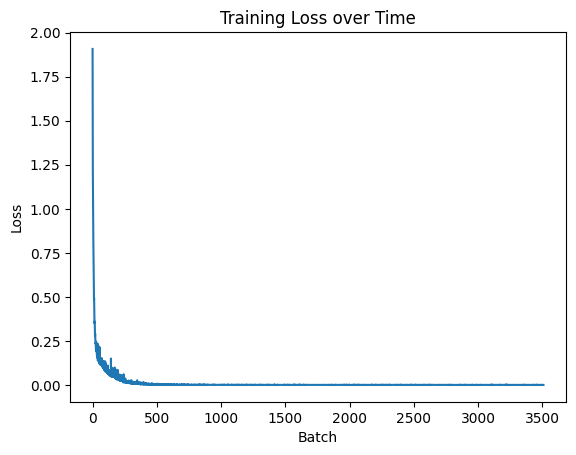

In [11]:
# 5. Training ----------------------------------------------------------------
# plot losses over time
# write me code to plot losses over time
losses = []
total_steps = len(loader) * EPOCHS
step_global = 0
for epoch in range(EPOCHS):
    pbar = tqdm(loader, leave=False)
    for step, (img, _) in enumerate(pbar):
        B, _, H, W = img.shape
        img = img.to(device)

        # ---- random target patch top-left corner ----
        PATCH_SZ1 = random.choice([10, 12, 14, 16])
        PATCH_SZ2 = random.choice([10, 12, 14, 16])

        i = random.randint(0, H - PATCH_SZ1)
        j = random.randint(0, W - PATCH_SZ2)
        target_patch = img[:, :, i:i+PATCH_SZ1, j:j+PATCH_SZ2]

        

        # ---- forward ----
        z_x   = x_enc(img)                    # context representation
        z_y   = y_enc(target_patch).detach()  # stop-gradient

        z_x   = nn.functional.normalize(z_x,  dim=1)
        z_y   = nn.functional.normalize(z_y.detach(), dim=1)
        z_y_hat = nn.functional.normalize(predictor(z_x), dim=1)
        loss = 2 - 2 * (z_y_hat * z_y).sum(dim=1).mean()   # in [0, 4]


        #z_y_hat = predictor(z_x)

        #loss = nn.functional.mse_loss(z_y_hat, z_y)

        # ---- update ----
        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
        losses.append(loss.item())

        # EMA update of y-encoder
        with torch.no_grad():
            # inside training loop
            ema_start, ema_end = 0.999, 0.9999
            EMA = ema_end - (ema_end - ema_start) * (1 + np.cos(np.pi * step_global / total_steps)) / 2
            step_global += 1
            for p_y, p_x in zip(y_enc.parameters(), x_enc.parameters()):
                p_y.copy_(EMA * p_y + (1 - EMA) * p_x)
        # print(f'step {step:4d} | loss {loss.item():.4f} | ' ,
        #       f'|z_x|={z_x.norm(dim=1).mean().item():.3f} | ',  f'|z_y|={z_y.norm(dim=1).mean().item():.3f}')

        if (epoch % 1 == 0  or epoch == EPOCHS-1) and step == len(loader)-1:
            X_tr, y_tr = embed_dataset(train_loader)
            X_te, y_te = embed_dataset(test_loader)
            clf = make_pipeline(StandardScaler(),
                                LogisticRegression(max_iter=5000, solver='lbfgs'))
            clf.fit(X_tr[:20000], y_tr[:20000])   # 20 k is enough
            print(f'epoch {epoch:02d}  acc {clf.score(X_te, y_te):.3f}')
        pbar.set_description(f"epoch {epoch}  loss {loss.item():.4f}, z_x {z_x.mean():.2f} {z_x.std():.2f}, z_y {z_y.mean():.2f} {z_y.std():.2f}, z_y_hat {z_y_hat.mean():.2f} {z_y_hat.std():.2f}")

# 6. Plotting losses over time
plt.plot(losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()

In [12]:
target_patch.shape

torch.Size([256, 1, 10, 12])

In [13]:
# 6. Quick sanity check ------------------------------------------------------
# freeze y_enc, train a tiny logistic reg on top → should get ≈ 95 % accuracy
def embed_dataset(loader):
    reps, labels = [], []
    for img, y in loader:
        with torch.no_grad():
            z = y_enc(img.to(device))
            z = nn.functional.normalize(z, dim=1)   # <- add this
            reps.append(z.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(reps), np.concatenate(labels)

train_loader = torch.utils.data.DataLoader(datasets.MNIST('.', train=True, transform=transform),
                                           batch_size=500, shuffle=False)
test_loader  = torch.utils.data.DataLoader(datasets.MNIST('.', train=False, transform=transform),
                                           batch_size=500, shuffle=False)

X_train, y_train = embed_dataset(train_loader)
X_test,  y_test  = embed_dataset(test_loader)


In [14]:
#clf = LogisticRegression(max_iter=1000, solver='lbfgs')

clf = make_pipeline(StandardScaler(),
                    LogisticRegression(max_iter=10000, solver='lbfgs'))
clf.fit(X_train, y_train)

print("Linear probe accuracy:", accuracy_score(y_test, clf.predict(X_test)))

Linear probe accuracy: 0.8924


In [ ]:
echo "# JEPA_Models" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/Iqbal1282/JEPA_Models.git
git push -u origin main